In [1]:
import os
!pip install opencv-python
!pip install geocoder
!pip install pandas
!pip install geopy
!pip install keras
!pip install twilio
!pip install  scikit-image
import cv2     # for capturing videos
import math 
import geocoder
import requests
%matplotlib inline
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from matplotlib import pyplot as plt 
from skimage.transform import resize   # for resizing images

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2023-05-28 09:01:00.057995: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-28 09:01:00.226178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 09:01:03.296887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 09:01:03.316376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 09:01:18.698111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


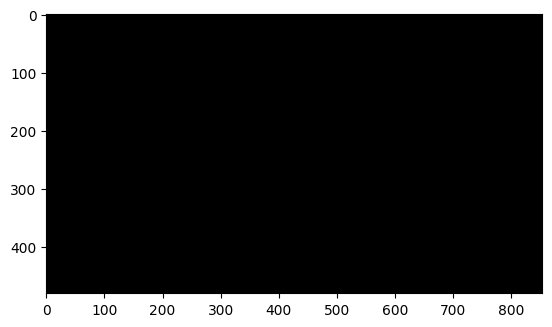

In [3]:
img = plt.imread('0.jpg')   # reading image using its name
plt.imshow(img)

In [4]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [5]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [6]:
y = data.Class
dummy_y = np_utils.to_categorical(y)

In [7]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [8]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [9]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


In [10]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

Defaulting to user installation because normal site-packages is not writeable


In [11]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

2023-05-28 09:02:54.570252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

3/3 [==============================] - 33s 8s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [14]:
X_train = X_train.reshape(155, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(67, 7*7*512)

In [15]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [16]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 25,693,186
Trainable params: 25,693,186
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
5/5 [==============================] - 8s 795ms/step - loss: 0.6142 - accuracy: 0.6710 - val_loss: 1.1979 - val_accuracy: 0.5672
Epoch 2/100
5/5 [==============================] - 3s 549ms/step - loss: 0.4417 - accuracy: 0.7677 - val_loss: 0.9949 - val_accuracy: 0.6269
Epoch 3/100
5/5 [==============================] - 3s 510ms/step - loss: 0.3478 - accuracy: 0.8000 - val_loss: 0.8529 - val_accuracy: 0.7015
Epoch 4/100
5/5 [==============================] - 3s 509ms/step - loss: 0.1840 - accuracy: 0.9097 - val_loss: 0.8770 - val_accuracy: 0.7761
Epoch 5/100
5/5 [==============================] - 2s 499ms/step - loss: 0.0779 - accuracy: 0.9871 - val_loss: 0.8440 - val_accuracy: 0.7164
Epoch 6/100
5/5 [==============================] - 2s 499ms/step - loss: 0.0959 - accuracy: 0.9613 - val_loss: 0.8504 - val_accuracy: 0.7015
Epoch 7/100
5/5 [==============================] - 2s 484ms/step - loss: 0.0452 - accuracy: 0.9935 - val_loss: 0.8075 - val_accuracy: 0.7761
Epoch 8/100
5

In [20]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [22]:
test = pd.read_csv('test.csv')

In [23]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [24]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [25]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image.shape

1/1 [==============================] - 20s 20s/step


(9, 7, 7, 512)

In [26]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [27]:
predictions = model.predict(test_image)

1/1 [==============================] - 8s 8s/step


In [28]:
print(predictions)

[[5.8879505e-06 9.9999416e-01]
 [3.3189068e-04 9.9966812e-01]
 [2.5760948e-03 9.9742389e-01]
 [1.2681657e-03 9.9873179e-01]
 [3.4257630e-03 9.9657428e-01]
 [5.8087718e-01 4.1912282e-01]
 [8.3983469e-01 1.6016532e-01]
 [6.6289109e-01 3.3710888e-01]
 [8.7880880e-01 1.2119119e-01]]


In [29]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")
    

No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident
Accident


In [4]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid ='ACffde3996b90ce28d94b2f451ca8c3ea3'
auth_token ='23c1cf93e4ed94e8aefa76daecd8d5bd'
client = Client(account_sid, auth_token)

NameError: name 'Nominatim' is not defined

In [3]:
from selenium import webdriver
from time import sleep
from selenium.webdriver.chrome.service import Service
import os
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait

In [2]:
cap = cv2.VideoCapture('Accident-1.mp4')
i=0
flag=0
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/15)%9][0]<predictions[int(i/15)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                predict,
                (50, 50),
                font, 1,
                (0, 255, 255),
                3,
                cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag==1:
    # os.system("gnome-terminal -- google-chrome-stable --remote-debugging-port=9988")
    # sleep(3)

    options = webdriver.ChromeOptions()
    options.add_experimental_option("debuggerAddress","localhost:9988")
    driver = webdriver.Chrome(service=Service(executable_path="/home/srihithreddy/Snapbot/chromedriver"),options=options)
    driver.get('')
    sleep(5)
    wait= WebDriverWait(driver,20)




NameError: name 'cv2' is not defined